/tmp/ipython-input-4038311610.py:130: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num_SP = np.trapz(E_extra_shell_SP[mask_outer_SP], r[mask_outer_SP])
/tmp/ipython-input-4038311610.py:131: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  den_SP = np.trapz(V_obs2, r)
/tmp/ipython-input-4038311610.py:141: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  num_CI = np.trapz(np.abs(dtau_obs - dtau_bar), r[1:])
/tmp/ipython-input-4038311610.py:142: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  den_CI = np.trapz(np.abs(dtau_bar),            r[1:])



===== Energy / L diagnostics (model) =====
Total ΔE_rot:        6.788082e+15
Outer ΔE_rot:        6.788049e+15
Fractional uplift (outer ΔE/Newtonian): 7.468
Total ΔL:            1.594571e+14
Outer ΔL:            1.594569e+14

===== Model indices (energy-lock vs Newtonian) =====
Curl_Index_model   = 1.9803
Surplus_Index_model= 1.0000

===== SPARC-style indices (using vN vs v_partial) =====
CurlIndex_SP       = 11.4933
SurplusIndex_SP    = 0.3112
Mean uplift <U>    = 6.8143
R_max              = 30.00 kpc



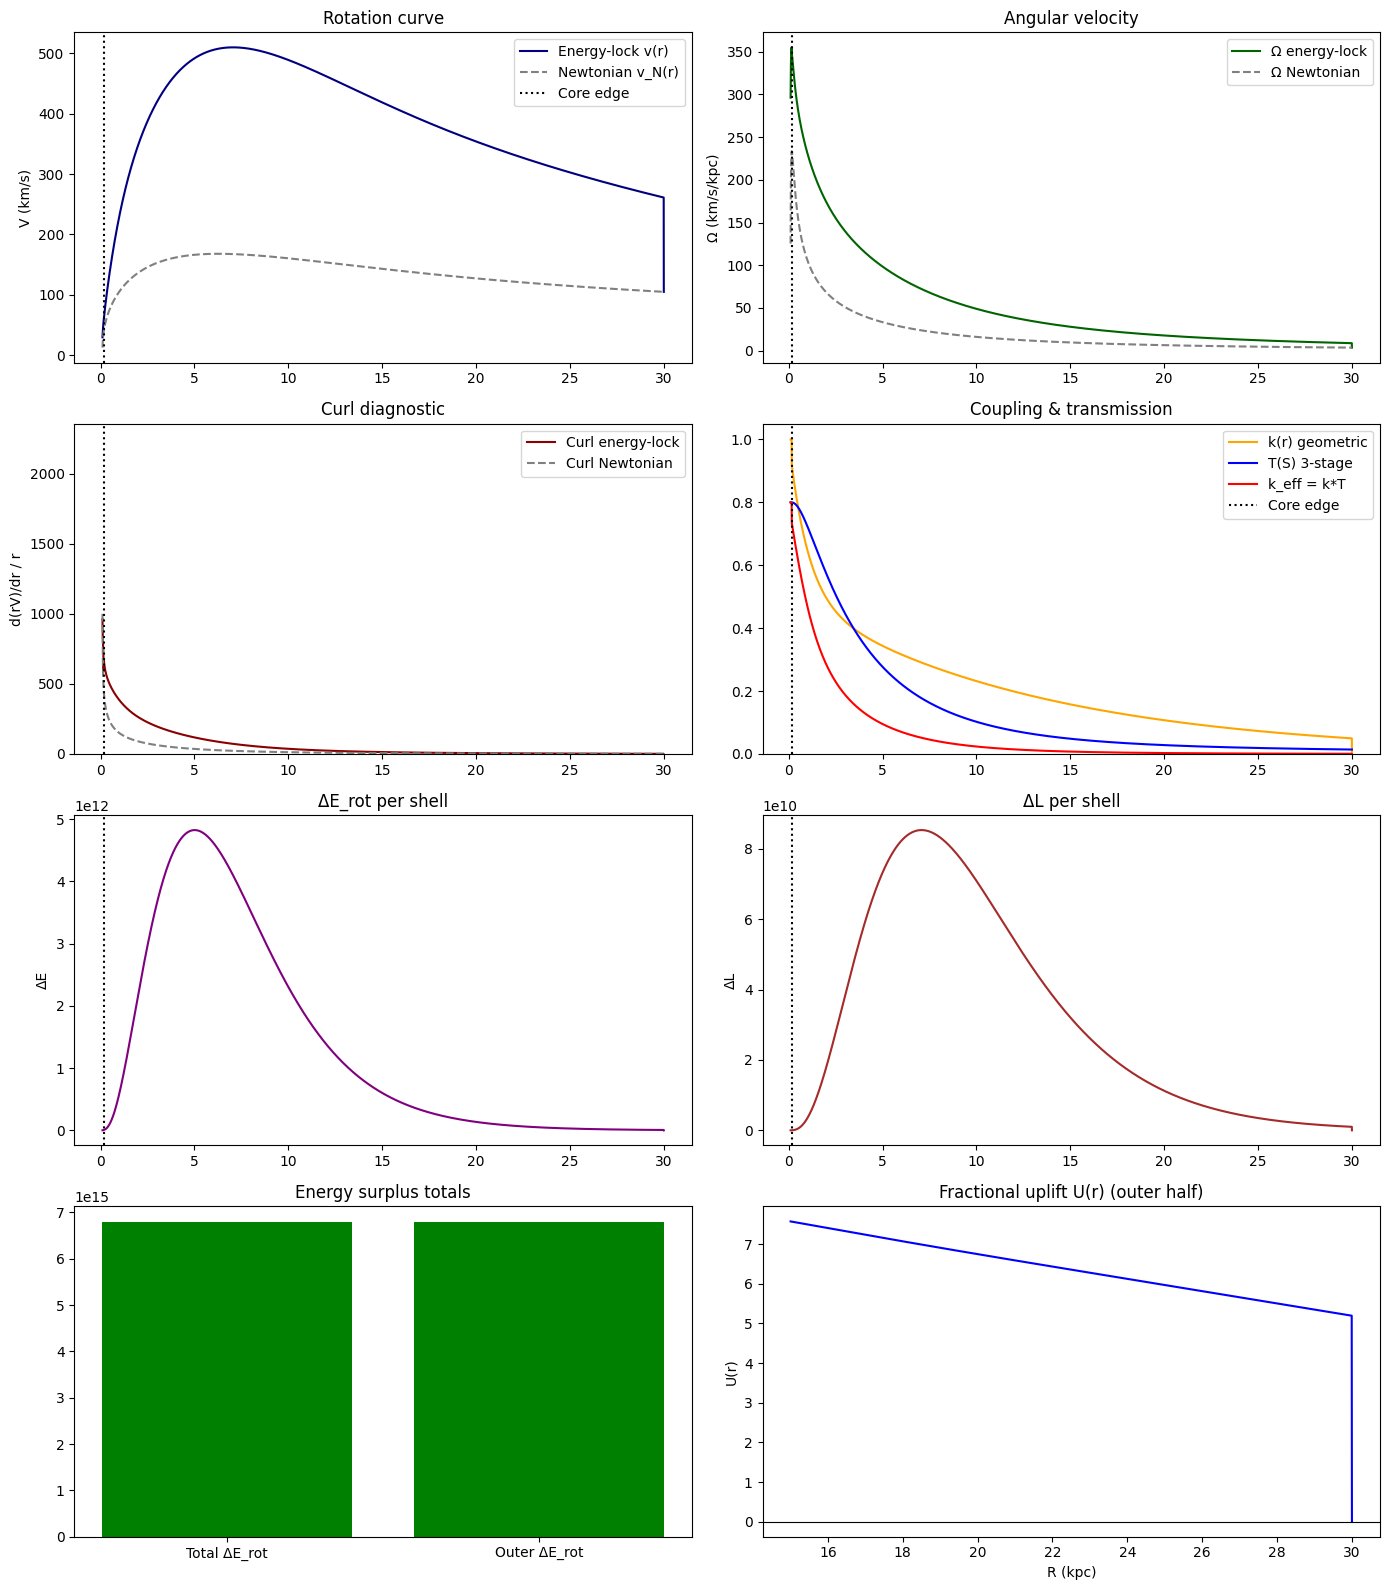

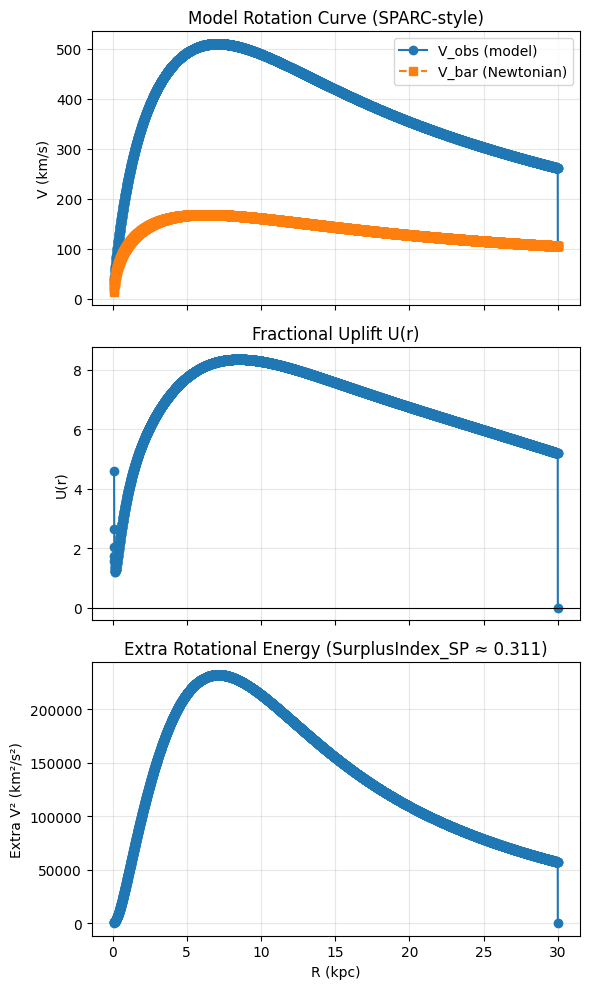

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# 0. Parameters
# ============================================================
N = 5000
r = np.linspace(0.1, 30.0, N)   # kpc
dr = r[1] - r[0]
idx = np.arange(N)

# Disk / gravity
Sigma0, R_d = 1e9, 3.5          # Msun/kpc^2, kpc
G = 4.302e-6                    # kpc·(km/s)^2 / Msun

# Inner “engine”
Omega_inner = 300.0             # km/s/kpc
i_solid = 10                    # rigid-core edge index

# Alternating-layer geometric coupling
Rk_alt  = 13                # kpc
Rk_star = 1                 # kpc

# Three-stage transmission parameters (tune these)
T_MAX = 0.8                     # max transmitted fraction
S0    = 0.1                     # curl-stress scale for bending/saturation

# Toggles
SOLID_LOCK = False
SMOOTH_K   = True

# ============================================================
# 1. Newtonian baseline: Σ(r), M(r), v_N(r), Ω_N(r)
# ============================================================
Sigma = Sigma0 * np.exp(-r / R_d)
m     = 2 * np.pi * r * dr * Sigma     # shell masses
Menc  = np.cumsum(m)

vN    = np.sqrt(G * Menc / np.maximum(r, 1e-6))
OmegaN = vN / r

def curl_from_v(r, v):
    rv = r * v
    return np.gradient(rv, r) / r

curl_N = curl_from_v(r, vN)

# ============================================================
# 2. Geometric coupling k(r) (gas vs. star shells)
# ============================================================
if SOLID_LOCK:
    k = np.ones_like(r)
else:
    k_even = np.exp(-r / Rk_alt)
    k_odd  = np.exp(-r / Rk_star)
    k      = np.where(idx % 2 == 0, k_even, k_odd)

# fully locked inner core
k[:i_solid] = 1.0

if SMOOTH_K:
    ks = k.copy()
    ks[1:-1] = 0.25*k[:-2] + 0.5*k[1:-1] + 0.25*k[2:]
    k = ks

# ============================================================
# 3. Three-stage transmission T(S)
#    Stage I: T ~ S (linear)
#    Stage II: bending
#    Stage III: T -> T_MAX (saturation)
# ============================================================
S_raw = np.abs(curl_N)
S     = S_raw / (S_raw.max() + 1e-12)      # dimensionless 0–1

T     = T_MAX * np.tanh(S / S0)            # three-stage map
k_eff = k * T                              # effective energy-coupling

# ============================================================
# 4. Energy-lock model (observed surrogate)
# ============================================================
v_partial_sq = vN**2 + k_eff * (Omega_inner * r)**2
v_partial    = np.sqrt(v_partial_sq)
Omega_partial = v_partial / r
curl_partial  = curl_from_v(r, v_partial)

# ============================================================
# 5. Energy & angular-momentum surplus diagnostics
# ============================================================
dE_shell = 0.5 * m * (v_partial**2 - vN**2)
dL_shell = m * r * (v_partial - vN)

E_surplus_total = dE_shell.sum()
E_surplus_outer = dE_shell[r > r[i_solid]].sum()

E_newt_outer    = (0.5 * m[r > r[i_solid]] * vN[r > r[i_solid]]**2).sum()
fE_outer        = E_surplus_outer / np.maximum(E_newt_outer, 1e-9)

L_surplus_total = dL_shell.sum()
L_surplus_outer = dL_shell[r > r[i_solid]].sum()

# “model” curl + surplus indices (energy-lock vs Newtonian)
mask_outer_model = idx > i_solid
curl_diff  = np.abs(curl_partial[mask_outer_model] - curl_N[mask_outer_model])
curl_base  = np.abs(curl_N[mask_outer_model])
Curl_Index_model = curl_diff.sum() / np.maximum(curl_base.sum(), 1e-9)

Surplus_Index_model = E_surplus_outer / np.maximum(E_surplus_total, 1e-9)

# ============================================================
# 6. SPARC-style indices using V_bar = vN, V_obs = v_partial
# ============================================================
V_bar = vN
V_obs = v_partial
V_bar2 = V_bar**2
V_obs2 = V_obs**2

eps = 1e-9
U = np.full_like(V_bar, np.nan)
mask_U = V_bar2 > eps
U[mask_U] = (V_obs2[mask_U] - V_bar2[mask_U]) / V_bar2[mask_U]
mean_U = np.nanmean(U)

# SPARC-style “extra V²” (per radius, not mass-weighted)
E_extra_shell_SP = np.clip(V_obs2 - V_bar2, 0, None)

R_max = r.max()
r0_SP = 0.5 * R_max
mask_outer_SP = r >= r0_SP

num_SP = np.trapz(E_extra_shell_SP[mask_outer_SP], r[mask_outer_SP])
den_SP = np.trapz(V_obs2, r)
SurplusIndex_SP = num_SP / np.maximum(den_SP, 1e-9)

# SPARC-style CurlIndex based on torque gradients
tau_obs = r * V_obs2
tau_bar = r * V_bar2
dR      = np.diff(r)
dtau_obs = np.diff(tau_obs) / dR
dtau_bar = np.diff(tau_bar) / dR

num_CI = np.trapz(np.abs(dtau_obs - dtau_bar), r[1:])
den_CI = np.trapz(np.abs(dtau_bar),            r[1:])
CurlIndex_SP = num_CI / np.maximum(den_CI, 1e-9)

# ============================================================
# 7. Text output (your “report style” printout)
# ============================================================
print("\n===== Energy / L diagnostics (model) =====")
print(f"Total ΔE_rot:        {E_surplus_total:.6e}")
print(f"Outer ΔE_rot:        {E_surplus_outer:.6e}")
print(f"Fractional uplift (outer ΔE/Newtonian): {fE_outer:.3f}")
print(f"Total ΔL:            {L_surplus_total:.6e}")
print(f"Outer ΔL:            {L_surplus_outer:.6e}")

print("\n===== Model indices (energy-lock vs Newtonian) =====")
print(f"Curl_Index_model   = {Curl_Index_model:.4f}")
print(f"Surplus_Index_model= {Surplus_Index_model:.4f}")

print("\n===== SPARC-style indices (using vN vs v_partial) =====")
print(f"CurlIndex_SP       = {CurlIndex_SP:.4f}")
print(f"SurplusIndex_SP    = {SurplusIndex_SP:.4f}")
print(f"Mean uplift <U>    = {mean_U:.4f}")
print(f"R_max              = {R_max:.2f} kpc\n")

# ============================================================
# 8. 8-panel diagnostic figure (model view)
# ============================================================
fig, axes = plt.subplots(4, 2, figsize=(14, 16))

# (1) Rotation curve
axes[0,0].plot(r, v_partial, label='Energy-lock v(r)', color='navy')
axes[0,0].plot(r, vN,         label='Newtonian v_N(r)', color='gray', linestyle='--')
axes[0,0].axvline(r[i_solid], color='black', linestyle=':', label='Core edge')
axes[0,0].set_title('Rotation curve')
axes[0,0].set_ylabel('V (km/s)')
axes[0,0].legend()

# (2) Angular velocity
axes[0,1].plot(r, Omega_partial, label='Ω energy-lock', color='darkgreen')
axes[0,1].plot(r, OmegaN,        label='Ω Newtonian',  color='gray', linestyle='--')
axes[0,1].axvline(r[i_solid], color='black', linestyle=':')
axes[0,1].set_title('Angular velocity')
axes[0,1].set_ylabel('Ω (km/s/kpc)')
axes[0,1].legend()

# (3) Curl diagnostic
axes[1,0].plot(r, curl_partial, label='Curl energy-lock', color='darkred')
axes[1,0].plot(r, curl_N,       label='Curl Newtonian',  color='gray', linestyle='--')
axes[1,0].axvline(r[i_solid], color='black', linestyle=':')
axes[1,0].set_title('Curl diagnostic')
axes[1,0].set_ylabel('d(rV)/dr / r')
axes[1,0].legend()
axes[1,0].set_ylim(bottom=0)

# (4) Coupling & three-stage transmission
axes[1,1].plot(r, k,     color='orange', label='k(r) geometric')
axes[1,1].plot(r, T,     color='blue',   label='T(S) 3-stage')
axes[1,1].plot(r, k_eff, color='red',    label='k_eff = k*T')
axes[1,1].axvline(r[i_solid], color='black', linestyle=':', label='Core edge')
axes[1,1].set_ylim(0, 1.05)
axes[1,1].set_title('Coupling & transmission')
axes[1,1].legend()

# (5) ΔE_rot per shell
axes[2,0].plot(r, dE_shell, color='purple')
axes[2,0].axvline(r[i_solid], color='black', linestyle=':')
axes[2,0].set_title('ΔE_rot per shell')
axes[2,0].set_ylabel('ΔE')

# (6) ΔL per shell
axes[2,1].plot(r, dL_shell, color='brown')
axes[2,1].axvline(r[i_solid], color='black', linestyle=':')
axes[2,1].set_title('ΔL per shell')
axes[2,1].set_ylabel('ΔL')

# (7) Energy surplus totals
axes[3,0].bar(['Total ΔE_rot','Outer ΔE_rot'],
              [E_surplus_total, E_surplus_outer],
              color='green')
axes[3,0].set_title('Energy surplus totals')

# (8) Fractional uplift U(r) in outer half
mask_outer_plot = r >= 0.5 * r.max()
axes[3,1].plot(r[mask_outer_plot], U[mask_outer_plot], color='blue')
axes[3,1].axhline(0, color='black', linewidth=0.8)
axes[3,1].set_title('Fractional uplift U(r) (outer half)')
axes[3,1].set_xlabel('R (kpc)')
axes[3,1].set_ylabel('U(r)')

plt.tight_layout()
plt.show()

# ============================================================
# 9. Optional: SPARC-style 3-panel figure for direct comparison
# ============================================================
fig2, ax2 = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# RC
ax2[0].plot(r, V_obs, 'o-', label="V_obs (model)")
ax2[0].plot(r, V_bar, 's--', label="V_bar (Newtonian)")
ax2[0].set_ylabel("V (km/s)")
ax2[0].set_title("Model Rotation Curve (SPARC-style)")
ax2[0].legend()
ax2[0].grid(alpha=0.3)

# U(r)
ax2[1].plot(r, U, 'o-')
ax2[1].axhline(0, color='k', linewidth=0.8)
ax2[1].set_ylabel("U(r)")
ax2[1].set_title("Fractional Uplift U(r)")
ax2[1].grid(alpha=0.3)

# Extra V^2
ax2[2].plot(r, E_extra_shell_SP, 'o-')
ax2[2].set_xlabel("R (kpc)")
ax2[2].set_ylabel("Extra V² (km²/s²)")
ax2[2].set_title(f"Extra Rotational Energy (SurplusIndex_SP ≈ {SurplusIndex_SP:.3f})")
ax2[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()
